In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kf_book.mkf_internal as mkf_internal
from filterpy.stats import plot_covariance_ellipse

## Multiplying Multidimensional Gaussians
We incorporated an uncertain measurement with an uncertain estimate by multiplying their Gaussians together. The result was another Gaussian with a smaller variance. If two pieces of uncertain information corroborate each other we should be more certain in our conclusion. The graphs look like this:

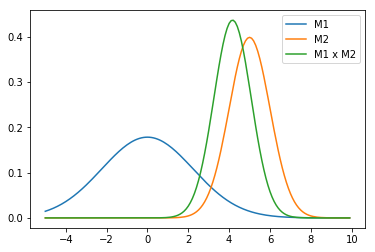

In [2]:
mkf_internal.plot_gaussian_multiply()

The combination of measurements 1 and 2 yields more certainty, so the new Gaussian is taller and narrower - the variance became smaller. The same happens in multiple dimensions with multivariate Gaussians.

Here are the equations for multiplying multivariate Gaussians. The capital sigma ($\Sigma$) indicates that these are matrices, not scalars. Specifically, they are covariance matrices:

$$\begin{aligned}
\mu &= \Sigma_2(\Sigma_1 + \Sigma_2)^{-1}\mu_1 + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\mu_2 \\
\Sigma &= \Sigma_1(\Sigma_1+\Sigma_2)^{-1}\Sigma_2
\end{aligned}$$

This computation is also available in FilterPy using the multivariate_multiply() method, which you can import from filterpy.stats.

To give you some intuition about this, recall the equations for multiplying univariate Gaussians:

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$
This looks similar to the equations for the multivariate equations. This will be more obvious if you recognize that matrix inversion, denoted by the -1 power, is like a reciprocal since $AA^{-1} =I$. I will rewrite the inversions as divisions - this is not a mathematically correct thing to do as division for matrices is not defined, but it does help us compare the equations.

$$\begin{aligned}
\mu &\approx \frac{\Sigma_2\mu_1 + \Sigma_1\mu_2}{\Sigma_1 + \Sigma_2} \\ \\
\Sigma &\approx \frac{\Sigma_1\Sigma_2}{(\Sigma_1+\Sigma_2)}
\end{aligned}$$
In this form the relationship between the univariate and multivariate equations is clear.

Now let's explore multivariate Gaussians in terms of a concrete example. Suppose that we are tracking an aircraft with two radar systems. I will ignore altitude so I can use two dimensional plots. Radar provides the range and bearing to a target. We start out being uncertain about the position of the aircraft, so the covariance, which is our uncertainty about the position, might look like this. In the language of Bayesian statistics this is our **prior**.

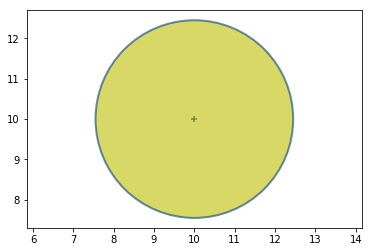

In [3]:
P0 = [[6, 0], [0, 6]]
plot_covariance_ellipse((10, 10), P0, fc='y', alpha=0.6)

Now suppose that there is a radar to the lower left of the aircraft. Further suppose that the radar's bearing measurement is accurate, but the range measurement is inaccurate. The covariance for the error in the measurement might look like this (plotted in green on top of the yellow prior):

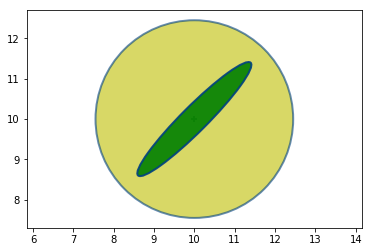

In [4]:
P1 = [[2, 1.9], [1.9, 2]]
plot_covariance_ellipse((10, 10), P0, fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P1, fc='g', alpha=0.9)

Bayesian statistics calls this the **evidence**. The ellipse points towards the radar. It is very long because the range measurement is inaccurate, and the aircraft could be within a considerable distance of the measured range. It is very narrow because the bearing estimate is very accurate and thus the aircraft must be very close to the bearing estimate. 

We want to find the **posterior** - the mean and covariance that results from incorporating the evidence into the prior. As in every other chapter we combine evidence by multiplying them together.

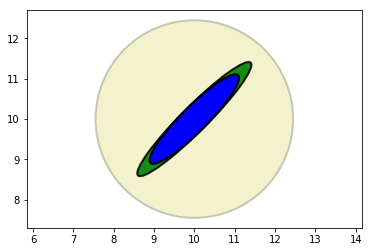

In [5]:
from filterpy.stats import multivariate_multiply

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, ec='k', fc='g', alpha=0.9)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='b')

The posterior retained the same shape and position as the radar measurement, but is smaller. We've seen this with one dimensional Gaussians. Multiplying two Gaussians makes the variance smaller because we are incorporating more information, hence we are less uncertain. Another point to recognize is that the covariance shape reflects the physical layout of the aircraft and the radar system.

Now let's say we get a measurement from a second radar, this one to the lower right. The posterior from the last step becomes our new prior, which I plot in yellow. The new measurement is plotted in green.

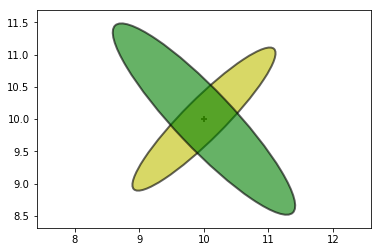

In [6]:
P3 = [[2, -1.9], [-1.9, 2.2]]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)

We incorporate this information by multiplying the Gaussians:

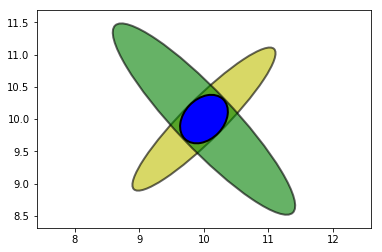

In [7]:
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, ec='k', fc='b')

The only likely place for the aircraft is where the two ellipses intersect. The intersection, formed by multiplying the prior and measurement, is a new Gaussian. The shapes reflects the geometry of the problem. This allows us to triangulate on the aircraft, resulting in a very accurate estimate. We didn't explicitly write any code to perform triangulation; it was a natural outcome of multiplying the Gaussians of each measurement together.

Let's consider a different layout. Suppose the first radar is directly to the left of the aircraft. I can model the measurement error with $$\Sigma = \begin{bmatrix}2& 0\\0& 0.2\end{bmatrix}$$

Here we see the result of multiplying the prior with the measurement.

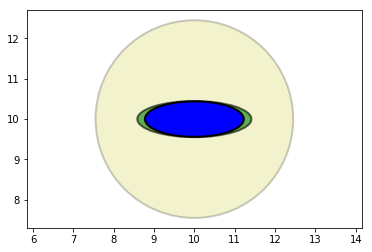

In [8]:
P1 = [[2, 0], [0, .2]]
P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='b')

Now we can incorporate the measurement from the second radar system, which we will leave in the same position as before.

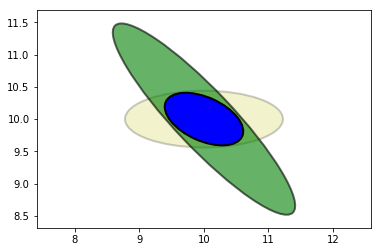

In [9]:
P3 = [[2, -1.9], [-1.9, 2.2]]
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, ec='k', fc='b')


Our estimate is not as accurate as the previous example. The two radar stations are no longer orthogonal to each other relative to the aircraft's position so the triangulation is not optimal.